In [15]:
import torch
import matplotlib.pyplot as plt

In [6]:
from my_dataloader import LoadDataset
from vit import ViT

device = 'cuda' if torch.cuda.is_available() else 'cpu'

14.0


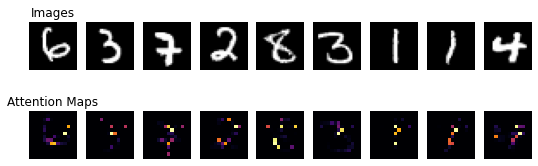

In [13]:
model_dict = torch.load("./myvit_mnist.pth")
in_channels = model_dict["in_channels"]
img_size = model_dict["img_size"]
emb_dim = model_dict["emb_dim"]
patch_size = model_dict["patch_size"]
num_heads = model_dict["num_heads"]
depth = model_dict["depth"]
mlp_ratio = model_dict["mlp_ratio"]
num_classes = model_dict["num_classes"]
epochs = model_dict["epochs"]
dataset_name = model_dict["dataset_name"]
model = ViT(in_channels, img_size, emb_dim, num_heads, patch_size, depth, mlp_ratio, num_classes).to(device)
model.load_state_dict(model_dict['model_state_dict'], strict=True)

model.eval()
model.to(device)

data = LoadDataset(dataset=dataset_name, mode="test", batch_size=1)
data.mode = True
data_loader = data.DataLoader()

imgs = []
attns = []
num_patches = (img_size // patch_size) ** 2

for i, (image, label) in enumerate(data_loader):
    image = image.to(device)

    scores, attn = model(image)
    cls_attn = torch.mean(attn, 1)
    cls_attn = cls_attn[:, 0, 1:].view(int(num_patches ** 0.5),int(num_patches ** 0.5))
    cls_attn = cls_attn.unsqueeze(-1)

    imgs.append(image.detach().cpu().numpy())
    attns.append(cls_attn.detach().cpu().numpy())

    if i == 10: break

plt.figure(figsize=(9, 3))
plt.gray()

for i, item in enumerate(imgs):
    if i >= 9: break
    if i == 0: plt.subplot(2, 9, i + 1, title="Images")
    else: plt.subplot(2, 9, i + 1)
    item = item.reshape(in_channels, img_size, img_size)
    # item: 1, 28, 28
    plt.axis('off')
    plt.imshow(item[0])

for i, item in enumerate(attns):
    if i >= 9: break
    if i == 0: plt.subplot(2, 9, 9 + i + 1, title="Attention Maps")
    else: plt.subplot(2, 9, 9 + i + 1)
    item = item.reshape(-1, int(num_patches ** 0.5), int(num_patches ** 0.5))
    # item: 1, 28, 28
    plt.axis('off')
    plt.imshow(item[0], cmap='inferno')

plt.show()

(-0.5, 13.5, 13.5, -0.5)

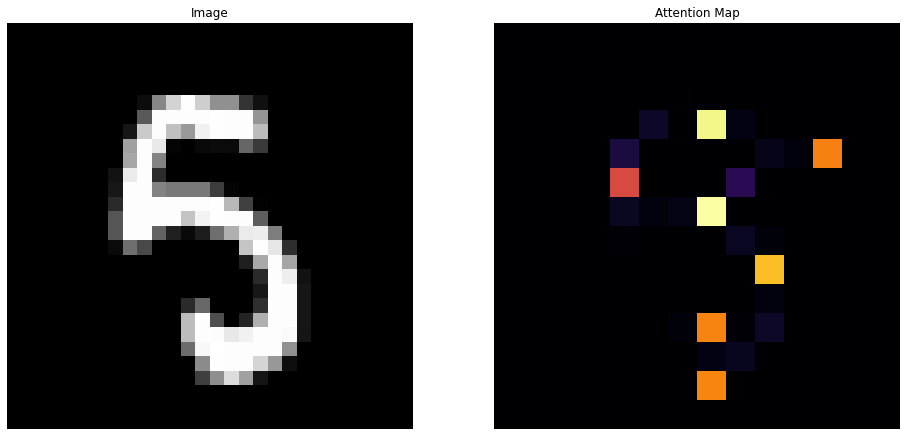

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Image')
ax2.set_title('Attention Map')
img = image.reshape(in_channels, img_size, img_size)
_ = ax1.imshow(img.detach().cpu().numpy())
ax1.axis('off')
_ = ax2.imshow(cls_attn.detach().cpu().numpy(), cmap='inferno')
ax2.axis('off')